In [1]:
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import timeit

from colorama import Fore
from sklearn.metrics import auc, roc_curve, precision_score, recall_score

In [2]:
from utils.vocab import Vocabulary
from utils.reader import Data
from utils.utils import print_progress, create_checkpoints_dir

In [3]:
params = {
    "batch_size": 128,
    "embed_size": 64,
    "hidden_size": 64,
    "num_layers": 2,
    "checkpoints": "./checkpoints/",
    "std_factor": 6.,
    "dropout": 0.7,
}

path_normal_data = "datasets/vulnbank_train.txt"
path_anomaly_data = "datasets/vulnbank_anomaly.txt"

# create_checkpoints_dir(params["checkpoints"])

vocab = Vocabulary()
params["vocab"] = vocab

d = Data(path_normal_data)

Downloaded 21991 samples


In [4]:
class Predictor():
    def __init__(self, checkpoints_path, std_factor, vocab):

        self.threshold = 0.
        self.checkpoints = checkpoints_path
        self.path_to_graph = checkpoints_path + 'seq2seq'
        self.std_factor = std_factor
        self.vocab = vocab
        self.__load()

    def __load(self):
        """
        Loads model from the checkpoint directory and sets models params.
        """
        try:
            loaded_graph = tf.Graph()
            with loaded_graph.as_default():
                saver = tf.train.import_meta_graph(
                    self.path_to_graph + '.meta')

            self.sess = tf.Session(graph=loaded_graph)
            saver.restore(self.sess, tf.train.latest_checkpoint(
                self.checkpoints))

            # loading model parameters
            self.inputs = loaded_graph.get_tensor_by_name('inputs:0')
            self.targets = loaded_graph.get_tensor_by_name('targets:0')
            self.lengths = loaded_graph.get_tensor_by_name('lengths:0')
            self.dropout = loaded_graph.get_tensor_by_name('dropout:0')
            self.batch_size_tensor = loaded_graph.get_tensor_by_name('batch_size:0')
            self.seq_len_tensor = loaded_graph.get_tensor_by_name('max_seq_len:0')
            self.get_batch_loss = loaded_graph.get_tensor_by_name('batch_loss:0')
            self.get_probabilities = loaded_graph.get_tensor_by_name('probs:0')
            self.get_logits = loaded_graph.get_tensor_by_name('logits:0')

        except Exception as e:
            raise ValueError('Unable to create model: {}'.format(e))

    def set_threshold(self, data_gen):
        """
        Calculates threshold for anomaly detection.
        """

        total_loss = []
        for seq, l in data_gen:
            batch_loss, _ = self._predict_for_request(seq, l)
            total_loss.extend(batch_loss)

        mean = np.mean(total_loss)
        std = np.std(total_loss)
        self.threshold = mean + self.std_factor * std

        print('Validation loss mean: ', mean)
        print('Validation loss std: ', std)
        print('Threshold for anomaly detection: ', self.threshold)

        return self.threshold

    def predict(self, data_gen, visual=True):
        """
        Predicts probabilities and loss for given sequences.
        """
        loss = []
        predictions = []
        num_displayed = 0

        for seq, l in data_gen:
            batch_loss, alphas = self._predict_for_request(seq, l)
            loss.extend(batch_loss)
            alphas = self._process_alphas(seq, alphas, 1)
            mask = np.array([l > self.threshold for l in batch_loss])
            final_pred = mask.astype(int)
            predictions.extend(final_pred)

            if visual and num_displayed < 10 and final_pred == [1]:
                print('\n\nPrediction: ', final_pred[0])
                print('Loss ', batch_loss[0])

                num_displayed += 1
                self._visual(alphas, seq)

        return predictions, loss

    def _predict_for_request(self, X, l):
        """
        Predicts probabilities and loss for given data.
        """
        lengths = [l]
        max_seq_len = l
        feed_dict = {
            self.inputs: X,
            self.targets: X,
            self.lengths: lengths,
            self.dropout: 1.0,
            self.batch_size_tensor: 1,
            self.seq_len_tensor: max_seq_len}

        fetches = [self.get_batch_loss, self.get_probabilities]
        batch_loss, alphas = self.sess.run(fetches, feed_dict=feed_dict)

        return batch_loss, alphas

    def _process_alphas(self, X, alphas, batch_size):
        """
        Counts numbers as probabilities for given data sample.
        """
        processed_alphas = []
        for i in range(batch_size):
            probs = alphas[i]
            coefs = np.array([probs[j][X[i][j]] for j in range(len(X[i]))])
            coefs = coefs / coefs.max()
            processed_alphas.append(coefs)

        return processed_alphas

    def _visual(self, alphas, X):
        """
        Colors sequence of malicious characters.
        """
        for i, x in enumerate(X):
            coefs = alphas[i]
            tokens = self.vocab.int_to_string(x)

            for j in range(len(x)):
                token = tokens[j]
                if coefs[j] < 0.09:
                    c = Fore.RED
                else:
                    c = Fore.GREEN
                if token != '<PAD>' and token != '<EOS>':
                    token = c + token.decode("utf-8")
                    print(token, end='')
                    pass

            print(Fore.BLACK + '', end='')

In [5]:
p = Predictor(params["checkpoints"], params["std_factor"], params["vocab"])

INFO:tensorflow:Restoring parameters from ./checkpoints/seq2seq-5163


In [6]:
val_gen = d.val_generator()
threshold = p.set_threshold(val_gen)

Validation loss mean:  0.0727657
Validation loss std:  0.11556394
Threshold for anomaly detection:  0.7661493197083473


In [7]:
# Benign samples

test_gen = d.test_generator()
valid_preds, valid_loss = p.predict(test_gen)



Prediction:  1
Loss  0.8893946
GET /vulnbank/assets/fonts/Pe-icon-7-stroke.woff?d7yf1v HTTP/1.1
Host: 10.0.212.25
Connection: keep-alive
Origin: http://10.0.212.25
User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/64.0.3282.186 Safari/537.36
Accept: */*
Referer: http://10.0.212.25/vulnbank/assets/css/pe-icon-7-stroke.css
Accept-Encoding: gzip, deflate
Accept-Language: en-US,en;q=0.9
Cookie: PHPSESSID=j1pavglp5ue30266c0j88ged30<EOS>

Prediction:  1
Loss  1.0210298
GET /vulnbank/assets/fonts/fontawesome-webfont.woff?v=4.2.0 HTTP/1.1
Host: 10.0.212.25
Connection: keep-alive
Origin: http://10.0.212.25
User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/64.0.3282.186 Safari/537.36
Accept: */*
Referer: http://10.0.212.25/vulnbank/assets/css/font-awesome.min.css
Accept-Encoding: gzip, deflate
Accept-Language: en-US,en;q=0.9
Cookie: PHPSESSID=j1pavglp5ue30266c0j88ged30<EOS>

Prediction:  1
Loss  0.8893946
GET /vuln

Cookie: PHPSESSID=j1pavglp5ue30266c0j88ged30<EOS>

Prediction:  1
Loss  0.8893946
GET /vulnbank/assets/fonts/Pe-icon-7-stroke.woff?d7yf1v HTTP/1.1
Host: 10.0.212.25
Connection: keep-alive
Origin: http://10.0.212.25
User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/64.0.3282.186 Safari/537.36
Accept: */*
Referer: http://10.0.212.25/vulnbank/assets/css/pe-icon-7-stroke.css
Accept-Encoding: gzip, deflate
Accept-Language: en-US,en;q=0.9
Cookie: PHPSESSID=j1pavglp5ue30266c0j88ged30<EOS>

Prediction:  1
Loss  1.0742682
GET /vulnbank/assets/fonts/glyphicons-halflings-regular.woff2 HTTP/1.1
Host: 10.0.212.25
Connection: keep-alive
Origin: http://10.0.212.25
User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/64.0.3282.186 Safari/537.36
Accept: */*
Referer: http://10.0.212.25/vulnbank/assets/css/bootstrap.min.css
Accept-Encoding: gzip, deflate
Accept-Language: en-US,en;q=0.9
Cookie: PHPSESSID=j1pavglp5ue30266c0j88ged3

type=user&action=create&username=hgjhg&password=123&firstname=jhgnbv&lastname=hgfhgf&birthdate=15-03-2046&email=hgfhghg%40ggg.com&phone=546544&account=DE35160051939300175381&creditcard=4556-3008-6605-2920<EOS>

Prediction:  1
Loss  1.0742682
GET /vulnbank/assets/fonts/glyphicons-halflings-regular.woff2 HTTP/1.1
Host: 10.0.212.25
Connection: keep-alive
Origin: http://10.0.212.25
User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/64.0.3282.186 Safari/537.36
Accept: */*
Referer: http://10.0.212.25/vulnbank/assets/css/bootstrap.min.css
Accept-Encoding: gzip, deflate
Accept-Language: en-US,en;q=0.9
Cookie: PHPSESSID=j1pavglp5ue30266c0j88ged30<EOS>

Prediction:  1
Loss  1.0742682
GET /vulnbank/assets/fonts/glyphicons-halflings-regular.woff2 HTTP/1.1
Host: 10.0.212.25
Connection: keep-alive
Origin: http://10.0.212.25
User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/64.0.3282.186 Safari/537.36
Accept: */*
Referer: 

In [8]:
print('Number of FP: ', np.sum(valid_preds))
print('Number of samples: ', len(valid_preds))
print('FP rate: {:.4f}'.format(np.sum(valid_preds) / len(valid_preds)))

Number of FP:  10
Number of samples:  2200
FP rate: 0.0045


# Anomalous samples
Here TP samples are showed and TP rate is computed.

In [9]:
pred_data = Data(path_anomaly_data, predict=True)
pred_gen = pred_data.predict_generator()
anomaly_preds, anomaly_loss = p.predict(pred_gen)

Downloaded 1097 samples


Prediction:  1
Loss  2.49534
POST /vulnbank/online/api.php HTTP/1.1
Host: 10.0.212.25
User-Agent: Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:59.0) Gecko/20100101 Firefox/59.0
Accept: application/json, text/javascript, */*; q=0.01
Accept-Language: en-US,en;q=0.5
Accept-Encoding: gzip, deflate
Referer: http://10.0.212.25/vulnbank/online/login.php
Content-Type: application/x-www-form-urlencoded; charset=UTF-8
X-Requested-With: XMLHttpRequest
Content-Length: 209
Cookie: PHPSESSID=mlacs0uiou344i3fa53s7raut6
Connection: keep-alive

type=user&action=create&username=Jack'+and+extractvalue(0x0a,concat(0x0a,(select version())))+and+'1'='1&password=passw0rd&firstname=first&lastname=last&birthdate=30-08-2017&email=eee%40mail.com&phone=747474747&account=DE44404419569750553340&creditcard=4556-9373-3913-6510<EOS>

Prediction:  1
Loss  2.491817
POST /vulnbank/online/api.php HTTP/1.1
Host: 10.0.212.25
User-Agent: Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:59.0) Gecko/20100101 

type=user&action=login&username=none'+union+select+1,2,login,password,5,6,7,NULL,NULL,10,11,12,13,14,15,16,17+from+users+limit+1+--1<EOS>

Prediction:  1
Loss  0.8652356
POST /vulnbank/online/api.php HTTP/1.1
Host: 10.0.212.25
User-Agent: Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:59.0) Gecko/20100101 Firefox/59.0
Accept: application/json, text/javascript, */*; q=0.01
Accept-Language: en-US,en;q=0.5
Accept-Encoding: gzip, deflate
Referer: http://10.0.212.25/vulnbank/online/transactions.php
Content-Type: application/x-www-form-urlencoded; charset=UTF-8
X-Requested-With: XMLHttpRequest
Content-Length: 162
Cookie: PHPSESSID=ch1upt4lk9onm6e26lo4lkc893
Connection: keep-alive

type=transaction&action=send&sender=DE00000111112222233333&recipient=DE11111656567474783838&creditcard=1234-6579-3514-6475&amount=2&comment=<svg onload=alert(1)><EOS>

Prediction:  1
Loss  9.947084
POST /vulnbank/onlinebank/api.php?xml HTTP/1.1
Host: vulnbank.com
User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv

<?xml version="1.0" encoding="utf-8"?><!DOCTYPE lolz [<!ENTITY lol "lol"><!ELEMENT login (#PCDATA)><!ENTITY lol1 "&lol;&lol;&lol;&lol;&lol;&lol;&lol;&lol;&lol;&lol;"><!ENTITY lol2 "&lol1;&lol1;&lol1;&lol1;&lol1;&lol1;&lol1;&lol1;&lol1;&lol1;"><!ENTITY lol3 "&lol2;&lol2;&lol2;&lol2;&lol2;&lol2;&lol2;&lol2;&lol2;&lol2;"><!ENTITY lol4 "&lol3;&lol3;&lol3;&lol3;&lol3;&lol3;&lol3;&lol3;&lol3;&lol3;"><!ENTITY lol5 "&lol4;&lol4;&lol4;&lol4;&lol4;&lol4;&lol4;&lol4;&lol4;&lol4;"><!ENTITY lol6 "&lol5;&lol5;&lol5;&lol5;&lol5;&lol5;&lol5;&lol5;&lol5;&lol5;"><!ENTITY lol7 "&lol6;&lol6;&lol6;&lol6;&lol6;&lol6;&lol6;&lol6;&lol6;&lol6;"><!ENTITY lol8 "&lol7;&lol7;&lol7;&lol7;&lol7;&lol7;&lol7;&lol7;&lol7;&lol7;"><!ENTITY lol9 "&lol8;&lol8;&lol8;&lol8;&lol8;&lol8;&lol8;&lol8;&lol8;&lol8;">]><api><type>user</type><action>forgotpass</action><username>j.doe</username><password>&lol9;</password><code>000</code></api><EOS>

Prediction:  1
Loss  1.721965
POST /vulnbank/online/api.php HTTP/1.1
Host: 10.0.212.2

Accept-Encoding: gzip, deflate
Accept-Language: en-US,en;q=0.9,ru;q=0.8
Cookie: PHPSESSID=7bgg5tald4aea80790it7s1cc1

type=user&action=infoupdate&firstname=John&lastname=Doe&phone=79035222212&email=j.doe%40vulnbank.de&birthdate=1984-04-04&about=Hi!<EOS>

Prediction:  1
Loss  4.81311
PUT /cvphqfymlt.txt HTTP/1.1
Host: 10.0.212.25
Content-Length: 10
Connection: close

mb470or8sl<EOS>

Prediction:  1
Loss  6.167886
TRACE / HTTP/1.1
Host: 10.0.212.25
Cookie: wd12kgj0o3
Connection: close<EOS>

Prediction:  1
Loss  4.302686
GET /clientaccesspolicy.xml HTTP/1.1
Host: 10.0.212.25
Connection: close<EOS>

Prediction:  1
Loss  4.933769
DEBUG /Default.aspx HTTP/1.1
Host: 10.0.212.25
Command: start-debug
Connection: close<EOS>

In [10]:
print('Number of TP: ', np.sum(anomaly_preds))
print('Number of samples: ', len(anomaly_preds))
print('TP rate: {:.4f}'.format(np.sum(anomaly_preds) / len(anomaly_preds)))

Number of TP:  1096
Number of samples:  1097
TP rate: 0.9991


# Testing
To evaluate the results, let's compute metrics of quality: precision, recall, ROC-AUC.

In [11]:
y_true = np.concatenate(([0] * len(valid_preds), [1] * len(anomaly_preds)), axis=0)
preds = np.concatenate((valid_preds, anomaly_preds), axis=0)
loss_pred = np.concatenate((valid_loss, anomaly_loss), axis=0)
assert len(y_true)==len(loss_pred)

In [12]:
precision = precision_score(y_true, preds)
recall = recall_score(y_true, preds)
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))

Precision: 0.9910
Recall: 0.9991


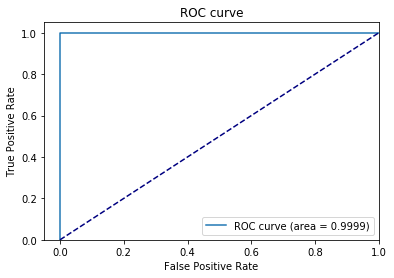

In [13]:
fpr, tpr, _ = roc_curve(y_true, loss_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()